# Research Skills: Image Analysis 
## Take-home Assignment - Part 2 
Sharon Ong, Department of Cognitive Science and Artificial Intelligence 

Tilburg University
Blok 3, Spring 2024

Your First Name: Christophe

Your Last Name: Friezas Gonçalves

Your Student ID: 2059012

Please include any special instructions to run your code, references to any code, methods, ideas that are not your own or not provided in this course here. 

In [1]:
#Here are the necessary imports to run the code
#The code itself uses code blocks from the given notebooks and small changes to it.
#The only function that I took from the internet or rather the implementation of it was the circle ploting in point 5

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import numpy as np

from scipy.ndimage import binary_fill_holes
from scipy.ndimage import distance_transform_edt

from skimage import feature,io, color
from skimage.color import label2rgb
from skimage.feature import peak_local_max
from skimage.filters import median,try_all_threshold
from skimage.measure import label, regionprops
from skimage.morphology import diamond, disk, opening, closing,dilation, erosion
from skimage.segmentation import watershed

%matplotlib inline

## Part 2: Processing an image of coins

1. (2 points) Load the image of coins you have been provided and display it with an appropriate title.

Text(0.5, 1.0, 'Original Image')

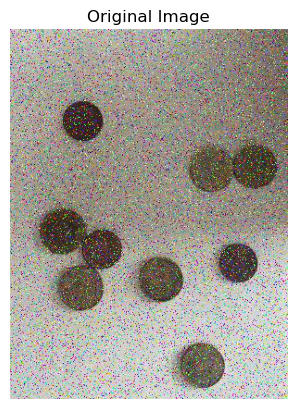

In [2]:
im = io.imread('2059012_coinimage.jpg')


plt.imshow(im)
plt.axis("off")
plt.title("Original Image")




2. (20 points) SSegment the coins to obtain a binary image where pixels representing the coins are set to 1.
You should compare two dierent image segmentation algorithms and you can apply image enhancement
techniques and morphological operations on these imagese..

   **Report the steps you took to compute two image segmentation algorithms as comments in your code. Display the results of image processing at each step with appropriate title

Possible segmentation techniques include Thresholding, Edge Detection, Hough Transforms, Superpixels 
and Graphcuts. Comparing two thresholding algorithms only count as 1 method. The morphologica 
operations are seen as pre or post processing operations. You can combine dierent techniques. F r
example, you can combine Thresholding with morphological operations and histogram equalization as
one solution and Edge detection followed by morphological operations as another solution.s.**

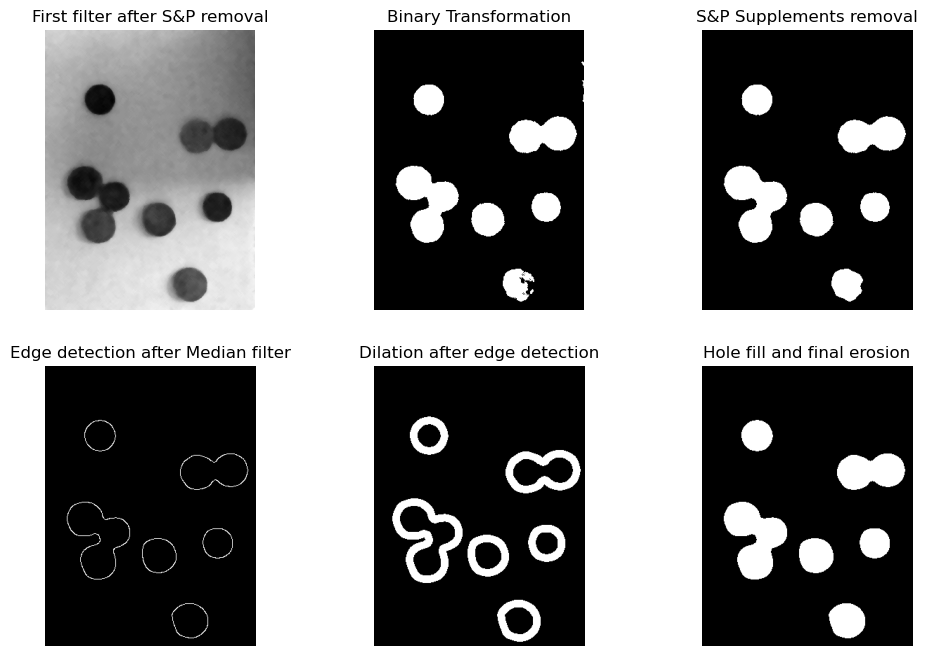

In [3]:
#I start of by transforming the image into grayscale and applying a median filter to smooth out the s&p noise

gr =color.rgb2gray(im)
g = median(gr, diamond(5))


plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(g, cmap = "gray")
plt.axis("off")
plt.title("First filter after S&P removal")


# Next I transform the image into a binary image by applying thresholding starting the first segmentation attempt
g= g.astype(float)
gray = g-g.min()                    
gray = gray/gray.max()
imbw = gray  < 0.35 #Number chosesn based on experimentation and output comparison

plt.subplot(232)
plt.imshow(imbw, "gray")
plt.axis("off")
plt.title("Binary Transformation")


#On the output we see remain white spots on the right and holes in one coin, we apply closing and opening to get rid of these
c = closing(imbw,disk(7))
o = opening(c,disk(3))



plt.subplot(233)
plt.imshow(o, "gray")
plt.axis("off")
plt.title("S&P Supplements removal")

#For the second attempt I start with canny edge detection to single out the coins. (Applied to the image after median smoothing)

edges = feature.canny(g, sigma=3)

plt.subplot(234)
plt.imshow(edges, "gray")
plt.axis("off")
plt.title("Edge detection after Median filter")

#I continue to dilate the coins for filling in the next step, given that the function would not fill these giant holes
di = dilation(edges, disk(5))

plt.subplot(235)
plt.imshow(di, "gray")
plt.axis("off")
plt.title("Dilation after edge detection")

#I fill in the holes and erode the result to get back to the original size coins 
fill = binary_fill_holes(di, structure=np.ones((3,3)))
er = erosion(fill, disk(5))


plt.subplot(236)
plt.imshow(er, "gray")
plt.axis("off")
plt.title("Hole fill and final erosion")
plt.show()

3. (5 points) Sets of white pixels which are connected to each other are called connected components or objects. Using your best segmentation result from Q2A.2, create code to connect all the connected 
components and visualize each connected component with a dierent color overlaid on the original image*

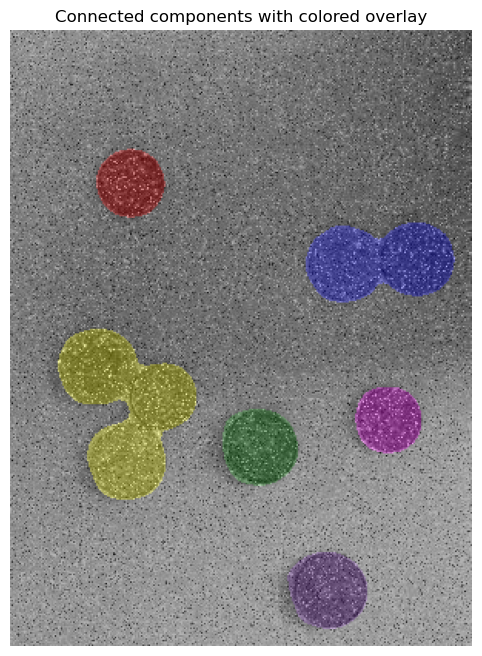

In [4]:
#For labeling we use the label function and transform the labeling to rgb to get colors as overlay

label_img = label(er)
over = label2rgb(label_img, image=im, bg_label = 0)


plt.figure(figsize=(8,8))
plt.imshow(over)
plt.axis("off")
plt.title("Connected components with colored overlay")
plt.show()

4. (10 points) Using your best segmentation result from Q2A.2, separate the touching coins and visualize each coin with a dierent color overlaid on the original image. Report the steps you took as comments in your code.

C:\Users\friez\AppData\Local\Temp\ipykernel_13788\2469967658.py:5: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxima = peak_local_max(distance, min_distance=5, footprint=np.ones((5, 5)), indices=False)


(<Axes: title={'center': 'Colored overlay'}>,
 (-0.5, 299.5, 399.5, -0.5),
 Text(0.5, 1.0, 'Colored overlay'))

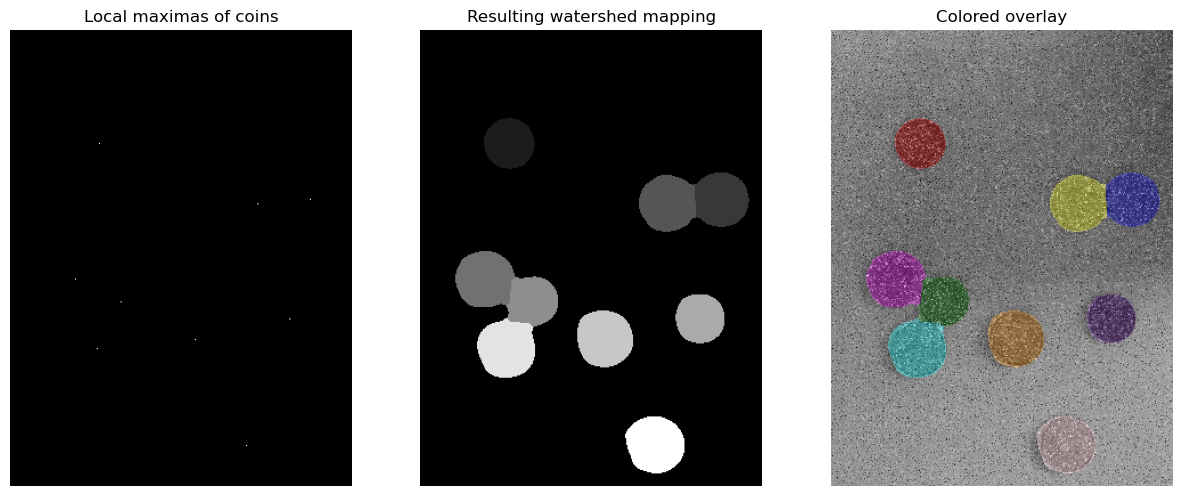

In [5]:
#To seperate the connected components we use the following function to extract basins
distance = distance_transform_edt(er)

#peak_local_max gives us the maximas of component, thus extracting centers of each coin
local_maxima = peak_local_max(distance, min_distance=5, footprint=np.ones((5, 5)), indices=False)

#I mark the coins and the watershed function return the seperated coins with an overlay
markers = label(local_maxima)
segmented = watershed(-distance, markers, mask=er)

#As previously the overlay is colored
over = label2rgb(segmented, image=im, bg_label = 0)

plt.figure(figsize=(15,8))
plt.subplot(131), plt.imshow(local_maxima, cmap='gray'), plt.axis('off'), plt.title('Local maximas of coins') 
plt.subplot(132), plt.imshow(segmented, cmap='gray'), plt.axis('off'), plt.title('Resulting watershed mapping') 
plt.subplot(133), plt.imshow(over, cmap='gray'), plt.axis('off'), plt.title('Colored overlay') 



5. (5 points) Show your original image with an overlay of bounding boxes or circular boundaries of each 
coin you found. You can use the segmentation results (from Q2A.2) or the original imagee.

   **Display the resulting images with appropriate titles. Print the number of coins. Report the steps you took as comments in your code.**

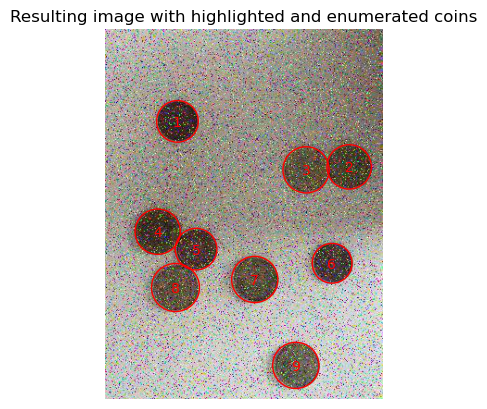

The code found 9 coins


In [6]:
#To get bounding boxes or in my case I prefered circles we need the regionsproperties
regions = regionprops(segmented)

#set up the plot
fig, ax = plt.subplots()
ax.imshow(im)
count =0

#I proceed by iterating over all image item
for prop in regions:
    #Extract the box information to calculate the diameter of the circle
    minr, minc, maxr, maxc = prop.bbox
    d = maxr-minr
    
    #Get the center of the coin
    cy,cx = prop.centroid
    
    #Increase the count for the print
    count+=1
    
    #Create and plot the circle
    cir =Circle( (cx, cy),d/2.0 , fill = False, color="r")
    ax.add_patch(cir)
    
    #Print a number to the coins for better visualisation
    ax.text(cx-5,cy+5,count,color="r")

plt.axis("off")
plt.title("Resulting image with highlighted and enumerated coins")
plt.show()
print("The code found",count, "coins")

6. (8 points) The image contains 5 cents and 50 cents. Indicate the amount of money your code finds in the image. Show your original image with an overlay of green points on the centroids of 5 cents and red points on the centroids of 50 cents.
   **Display the resulting images with appropriate titles. Print the amount of money in the image. Report the steps you took as comments in your code.**

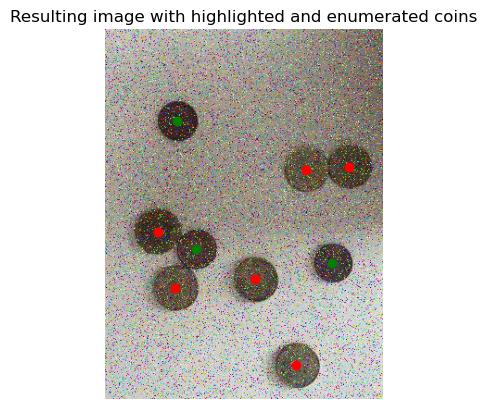

The total sum of coins equals to 3 euro and 15 cents


In [7]:
fig, ax = plt.subplots()
ax.imshow(im)
count =0
money=0

#I iterate again over all image items(coins)
for prop in regions:
    #I keep calculating the diameter for later comparison
    minr, minc, maxr, maxc = prop.bbox
    d = maxr-minr
    
    #Extract the center of our coins
    cy,cx = prop.centroid
    
    #To determine if we have a 5 cent or 50 cent coin we compare the size of the coins
    #the value again is based on experimentation and size value comaprison during experimentation
    if d>45:
        ax.scatter(cx,cy,color="r")
        money+=50
    else:
        ax.scatter(cx,cy,color="g")
        money+=5


plt.axis("off")
plt.title("Resulting image with highlighted and enumerated coins")
plt.show()
print("The total sum of coins equals to",int(money/100),"euro and", (money%100),"cents")